# Lomb-Scargle Failure Modes

Use simulated data to explore failure modes of periodograms

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

import numpy as np
from astropy.stats import LombScargle

In [2]:
def iter_fits(num_fits=1000, num_obs=60, days=180,
              mag=20, amp=1, dy=0.15, period_range=(0.7, 0.2),
              rseed=547398):
    """Iterator over fits to generated light curves"""
    rng = np.random.RandomState(rseed)
    for fit in range(num_fits):
        period = period_range[0] + period_range[1] * rng.randn()
        phase = rng.rand(3)
        a = [amp, 0.9 * amp, 0.5 * amp]
        t = rng.randint(0, days, num_obs) + 0.1 * rng.rand(num_obs)
        y = (mag +
             a[0] * np.sin(2 * np.pi * (t - phase[0]) / period) + 
             a[1] * np.sin(4 * np.pi * (t - phase[0]) / period) + 
             a[2] * np.sin(6 * np.pi * (t - phase[0]) / period) + 
             dy * rng.randn(num_obs))

        ls = LombScargle(t, y, dy)
        freq, power = ls.autopower(minimum_frequency=1. / 2.2,
                                   maximum_frequency=1. / 0.1)
        best_freq = freq[np.argmax(power)]
        
        yield (period, 1. / best_freq)

results = np.asarray(list(iter_fits(1000)))

/Users/jakevdp/anaconda/envs/python3.5/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


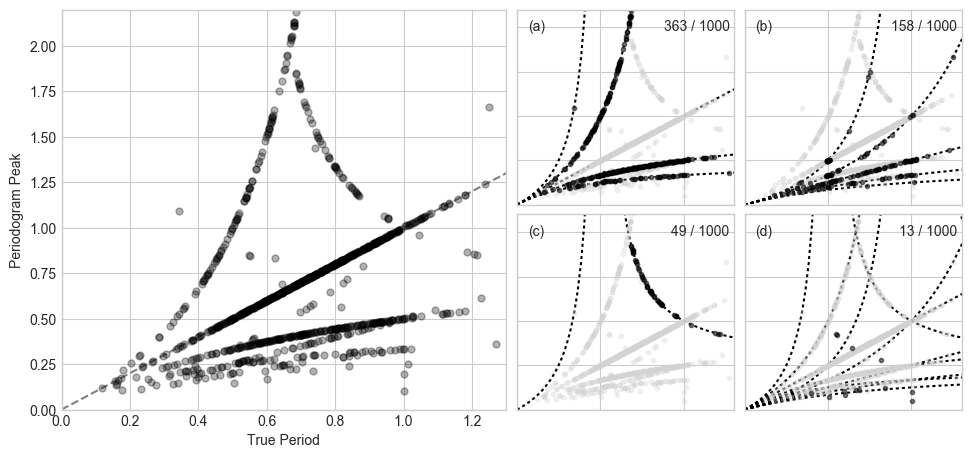

In [3]:
def fn(P, n, use_abs=False):
    ret = P / (1 - n * P)
    if use_abs:
        return abs(ret)
    else:
        ret[ret < 0] = np.inf
        return ret


def plot_guidelines(ax, n_values=[-2, -1, 0, 1, 2], alias=[1, 2],
                    use_abs=False, linestyle=':', color='black'):
    x = np.linspace(0, 2, 100)
    return [ax.plot(x, fn(x / a, n, use_abs), ':', color=color)
            for a in alias for n in n_values]


fig = plt.figure(figsize=(10, 5))
gs = plt.GridSpec(2, 4,
                  left=0.05, right=0.95, wspace=0.05,
                  bottom=0.1, top=0.9, hspace=0.05)

# Main plot: show true vs measured period
ax = fig.add_subplot(gs[:, :2])

true_period = results[:, 0]
estimated_period = results[:, 1]

ax.plot([0, 2], [0, 2], '--', color='gray')
ax.plot(true_period, estimated_period, 'ok', markersize=5, alpha=0.3);

ax.set(xlabel='True Period',
       ylabel='Periodogram Peak');

# Inset axes: show individual contributions

def plot_inset(ax, mask):
    ax.plot(true_period, estimated_period,'o',
            color='lightgray', markeredgecolor='lightgray',
            markersize=3, alpha=0.3, rasterized=True)
    ax.plot(true_period[mask],
            estimated_period[mask],
            'ok', markersize=3, alpha=0.5);
    ax.text(0.98, 0.95, '{0} / 1000'.format(mask.sum()),
            ha='right', va='top', transform=ax.transAxes)

ax = np.array([[fig.add_subplot(gs[i, j]) for j in (2, 3)]
                for i in (0, 1)])

plot_guidelines(ax[0, 0], alias=[1])
plot_guidelines(ax[0, 1], alias=[2])
plot_guidelines(ax[1, 0], alias=[1], n_values=[2], use_abs=True)
plot_guidelines(ax[1, 1], use_abs=True)

eps = 0.01

total_mask = (abs(estimated_period - true_period) < eps)

for i, a in enumerate([1, 2]):
    mask = False
    for j, n in enumerate([-2, -1, 0, 1, 2]):
        if a == 1 and n == 0:
            continue
        mask |= abs(estimated_period - fn(true_period / a, n)) < eps
    plot_inset(ax[0, i], mask)
    total_mask |= mask

mask_neg = ~total_mask & (abs(estimated_period - fn(true_period, 2, True)) < eps)
total_mask |= mask_neg

plot_inset(ax[1, 0], mask_neg)
plot_inset(ax[1, 1], ~total_mask)

for ax in fig.axes:
    ax.set(xlim=(0, 1.3), ylim=(0, 2.2));
    
for ax, label in zip(fig.axes[1:], 'abcd'):
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    ax.text(0.05, 0.95, '({0})'.format(label), ha='left', va='top',
            transform=ax.transAxes)
    
fig.savefig('fig25_failure_modes.pdf')